In [0]:
wh!pip install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

training_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
validation_dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=100,shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100,shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8884314.63it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135261.25it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2021383.59it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51061.04it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  #print(image.shape)
  #retirar a normalização
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

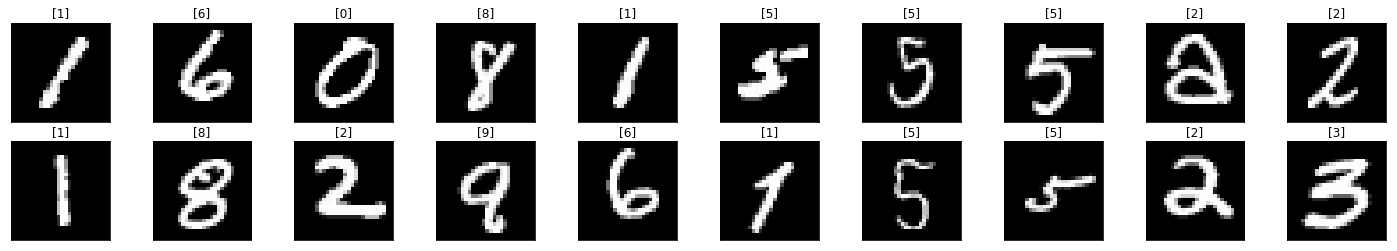

In [0]:
dataiter = iter(training_loader)
images,labels = dataiter.next()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,20,5,1)
    self.conv2 = nn.Conv2d(20,50,5,1)
    self.fc1 = nn.Linear(4*4*50,500)
    self.dropout1 = nn.Dropout(0.5) #colocar dropout pra evirar overfitting (colocar onde há bastante parametros)
    self.fc2 = nn.Linear(500,10)    
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)#colocar dropout pra evirar overfitting (colocar onde há bastante parametros)
    x = self.fc2(x)
    return x
  

In [0]:
model = LeNet().to(device)
model


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [0]:
epochs = 23
running_loss_history=[]
running_corrects_history=[]

val_running_loss_history=[]
val_running_corrects_history=[]


for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _,preds = torch.max(outputs,1)    
    running_loss += loss.item()
    running_corrects+= torch.sum(preds == labels.data)    
    
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)        
        
        _,val_preds = torch.max(val_outputs,1)
        val_running_loss += val_loss.item()
        val_running_corrects+= torch.sum(val_preds == val_labels.data)  
      
    epoch_loss = running_loss/len(training_loader)
    #epoch_loss = calcula o loss function atual
    epoch_acc = running_corrects.float()/len(training_loader)
    #epoch_acc = pega a quantiade de acertos que teve em relacao ao total e seta a porcentagem de acertos
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    #epoch_loss = calcula o loss function atual
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    #epoch_acc = pega a quantiade de acertos que teve em relacao ao total e seta a porcentagem de acertos
    val_running_loss_history.append(val_epoch_loss)    
    val_running_corrects_history.append(val_epoch_acc)    
    
    print('epoch: ',str(e+1))
    print('training_loss: {:.4f},{:.4f}'.format(epoch_loss,epoch_acc.item()))
    print('validation_loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))


epoch:  1
training_loss: 0.5662,84.8433
validation_loss: 0.1850, validation acc 94.5200
epoch:  2
training_loss: 0.1538,95.4700
validation_loss: 0.1071, validation acc 96.8900
epoch:  3
training_loss: 0.1019,96.9933
validation_loss: 0.0797, validation acc 97.5200
epoch:  4
training_loss: 0.0796,97.6133
validation_loss: 0.0649, validation acc 98.0200
epoch:  5
training_loss: 0.0665,97.9583
validation_loss: 0.0503, validation acc 98.4400
epoch:  6
training_loss: 0.0572,98.2867
validation_loss: 0.0493, validation acc 98.4400
epoch:  7
training_loss: 0.0502,98.5000
validation_loss: 0.0436, validation acc 98.6300
epoch:  8
training_loss: 0.0440,98.6650
validation_loss: 0.0412, validation acc 98.6900
epoch:  9
training_loss: 0.0401,98.7933
validation_loss: 0.0396, validation acc 98.7600
epoch:  10
training_loss: 0.0361,98.8700
validation_loss: 0.0358, validation acc 98.9000
epoch:  11
training_loss: 0.0332,98.9450
validation_loss: 0.0367, validation acc 98.7500
epoch:  12
training_loss: 0.03

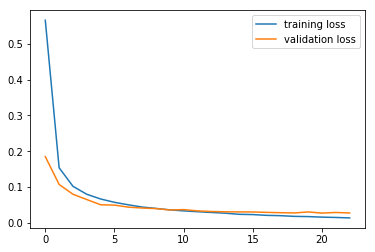

In [0]:
plt.plot(running_loss_history,label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()

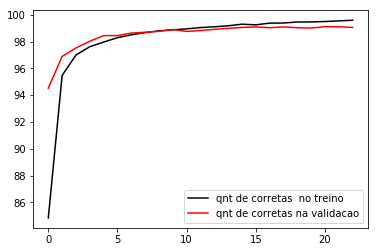

In [0]:
plt.plot(running_corrects_history,label='qnt de corretas  no treino',color="black")
plt.plot(val_running_corrects_history,label='qnt de corretas na validacao', color='red')
plt.legend()

<Response [200]>


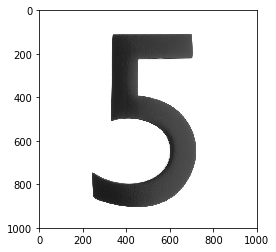

In [0]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg%20%20%20%20Course%20content'
response = requests.get(url,stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

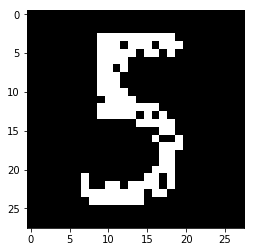

In [0]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [0]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(pred.item())


5


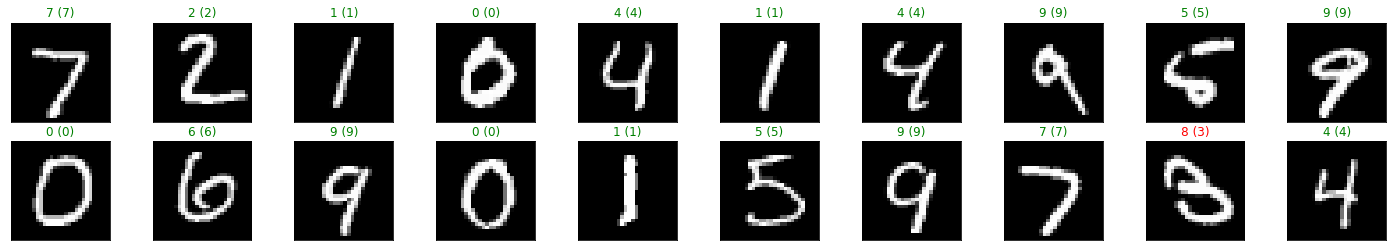

In [0]:
dataiter = iter(validation_loader)
images,labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_,preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))


for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()),str(labels[idx].item())),color=('green' if preds[idx]==labels[idx] else "red"))

<Response [200]>


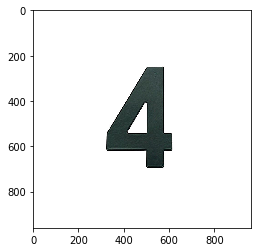

In [0]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://telhanorte.vteximg.com.br/arquivos/ids/338302-960-960/Numero-4-de-aco-com-bucha-e-parafuso-145cm-preto-Bemfixa.jpg?v=636868969670370000'
response = requests.get(url,stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)



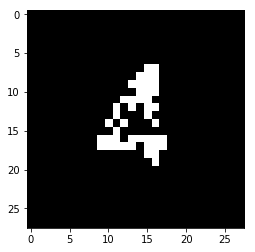

In [0]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [0]:
#img = img.view(img.shape[0],-1)
#output = model(img)
#_,pred = torch.max(output,1)
#print(pred.item())


images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
#print('images',images)
#print('unsqueeze',image)
output = model(image)
_,pred = torch.max(output,1)
print(pred.item())


4


<Response [200]>
4


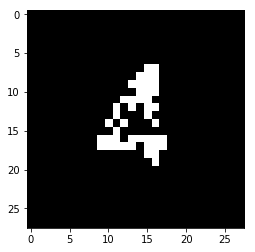

In [0]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://telhanorte.vteximg.com.br/arquivos/ids/338302-960-960/Numero-4-de-aco-com-bucha-e-parafuso-145cm-preto-Bemfixa.jpg?v=636868969670370000'
response = requests.get(url,stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))


images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
#print('images',images)
#print('unsqueeze',image)
output = model(image)
_,pred = torch.max(output,1)
print(pred.item())

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
image = Image.open(os.path.join("/content/drive/My Drive/Colab_Notebooks/Resources/numeros_a_mao","4.JPG"))
print(image)

In [0]:
print(images)

In [0]:
import requests
from PIL import Image
import PIL.ImageOps

# o 1 ele acha que é 9
# o 2 certo
# o 3 certo
# o 4 ele acha que é 7
# o 4_2 ele acha que é 9
# o 5 certo
# o 6 certo
# o 7 certo
# o 8 ele acha que é 6 (compreensivel)
# o 8_2 certo
# o 9 ele acha que é 5 




img = Image.open(os.path.join("/content/drive/My Drive/Colab_Notebooks/Resources/numeros_a_mao","9.JPG"))
plt.imshow(img)
print(response)
  
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
#print('images',images)
#print('unsqueeze',image)
output = model(image)
_,pred = torch.max(output,1)
print(pred.item())

In [0]:
#teste sm s

In [0]:
pip install selenium


In [0]:
install chromium-browser


In [0]:
from selenium import webdriver 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By 
import time 
  
# Replace below path with the absolute path 
# to chromedriver in your computer 
#/tmp/chromedriver.exe
#driver = webdriver.Chrome('/home/saket/Downloads/chromedriver') 
driver = webdriver.Chrome('/tmp/chromedriver.exe') 
  
driver.get("https://web.whatsapp.com/") 
wait = WebDriverWait(driver, 600) 
  
# Replace 'Friend's Name' with the name of your friend  
# or the name of a group  
target = '"Friend\'s Name"'
  
# Replace the below string with your own message 
string = "Message sent using Python!!!"
  
x_arg = '//span[contains(@title,' + target + ')]'
group_title = wait.until(EC.presence_of_element_located(( 
    By.XPATH, x_arg))) 
group_title.click() 
inp_xpath = '//div[@class="input"][@dir="auto"][@data-tab="1"]'
input_box = wait.until(EC.presence_of_element_located(( 
    By.XPATH, inp_xpath))) 
for i in range(100): 
    input_box.send_keys(string + Keys.ENTER) 
    time.sleep(1) 